# Prelim

## Imports

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import spacepy
from spacepy.coordinates import Coords
from spacepy.time import Ticktock
from spacepy import pycdf

from time import strftime, localtime
from datetime import datetime, timedelta
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# LUNA Directories
spacecraft_dir = 'Z:/spacecraft/cluster/c1/C1_CP_FGM_5VPS/'
omni_dir = 'Z:/omni/'

cdf_directory = os.path.join(spacecraft_dir, '2020/')
asc_directory = os.path.join(omni_dir, 'omni_1min_yearly/')

# Define the date range to extract data
start_date = datetime(2020, 1, 1) # inclusive
end_date = datetime(2021, 1, 1) # exclusive

start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

R_E = 6370     # Cluster takes 1 earth radius to be 6370 km
R_E = 6378.137 # Spacepy takes 1 earth radius to be 6370 km 

bin_size = 60000 # 60,000 ms = 1 min

# Output CDF file path
cluster_data_processed = 'Processed_Cluster_Data_2020.cdf'
omni_data_processed = 'Processed_Omni_Data_2020.cdf'

# Data to be extracted from cluster
cluster_variables = {
    'epoch' : 'time_tags__C1_CP_FGM_5VPS', # extracts the epoch time in milliseconds (scalar).
    'B' : 'B_vec_xyz_gse__C1_CP_FGM_5VPS',  # extracts the fgm data in nT (vector).
    'r' : 'sc_pos_xyz_gse__C1_CP_FGM_5VPS' # extracts the position in km from centre of Earth (vector).
}

omni_variables = ['time','B_field']

## Definitions

### Cluster

*  "C1" = Cluster 1
*  "CP" = Cluster Prime Parameter
*  "FGM" = Flux Gate Magnetometer
*  "5VPS" = 5 vectors/second resolution
*  Skeleton table: https://spdf.gsfc.nasa.gov/pub/software/cdawlib/0SKELTABLES/c1_cp_fgm_5vps_00000000_v01.skt

In [3]:
def find_cdf_files(directory, start_date, end_date):
    """
    Filters cdf files in a given directory based on a specified date range.

    Parameters
    ----------
    directory : str
        The path to the directory containing the cdf files.
        
    start_date : datetime
        The starting date of the range for which files should be selected.
        
    end_date : datetime
        The ending date of the range for which files should be selected.

    Returns
    -------
    list of str :
        A list of file paths for cdf files whose dates fall within the specified range.
    """
    cdf_files = []
    for file in sorted(os.listdir(directory)):
        if file.endswith('.cdf'):
            # Assuming filename is data-name__dates_version.cdf
            date_str = file.split('__')[1][:8]  # Get the first 8 characters after '__' (YYYYMMDD)
            file_date = datetime.strptime(date_str, '%Y%m%d')
            
            # Check if file_date is within the date range
            if start_date <= file_date < end_date:
                cdf_files.append(os.path.join(directory, file))
    
    return cdf_files

In [4]:
def extract_cdf_data(cdf_file, variables):
    """
    Loads specified variables from a CDF file and returns a dictionary with extracted data.

    Parameters
    ----------
    cdf_file : str
        The path to the CDF file.
        
    variables : dict
        Dictionary where keys are the variable names to be used in the dataframe, 
        and values are the variable codes used to extract data from the CDF file.

    Returns
    -------
    dict :
        A dictionary where keys are variable names, and values are the corresponding data arrays.
    """
    
    # Initialise a dictionary to store the data
    data_dict = {}

    # Load the CDF file (auto closes)
    with pycdf.CDF(cdf_file) as cdf:
    
        # Loop through the dictionary of variables and extract data
        for var_name, var_code in variables.items():
            if var_name == 'epoch': # prevents auto conversion to datetime from float
                data = cdf.raw_var(var_code)[...]
            else:
                data = cdf[var_code][...]  # Extract the data using the CDF variable code
    
            # Handle vector data
            if data.ndim == 2 and data.shape[1] == 3:  # Assuming a 2D array for vector components
                if var_name == 'r':
                    data /= R_E # scales distances to multiple of Earth radii
                
                # Calculate the magnitude of the vector
                data_dict[f'{var_name}_mag'] = np.linalg.norm(data, axis=1)
                
                # Split into components (e.g. x, y, z)
                data_dict[f'{var_name}_x_GSE'] = data[:, 0]
                data_dict[f'{var_name}_y_GSE'] = data[:, 1]
                data_dict[f'{var_name}_z_GSE'] = data[:, 2]
            # Scalar data
            else:
                # Store the data in the dictionary with the desired variable name
                data_dict[var_name] = data # pycdf extracts as datetime - no conversion from epoch needed
    
    return data_dict

In [5]:
def process_cdf_files(cdf_files, variables, output_cdf_file):
    """
    Processes a list of CDF files and extracts the specified variables, returning a pandas DataFrame.

    Parameters
    ----------
    cdf_files : list of str
        List of paths to the CDF files to be processed.
        
    variables : dict
        Dictionary where keys are the variable names to be used in the dataframe, 
        and values are the variable codes used to extract data from the CDF file.

    Returns
    -------
    pandas.DataFrame : one column for each variable :
        A DataFrame containing the extracted data from the CDF files, with scalar variables as columns,
        vector components as separate columns, and the magnitude of vectors.
    """

    # Check if the CDF file already exists
    cdf_file_exists = os.path.exists(output_cdf_file)

    with pycdf.CDF(output_cdf_file, create=not cdf_file_exists) as cdf_out:
        cdf_out.readonly(False)
        if not cdf_file_exists:
            cdf_out.attrs['Author'] = 'Joel Richardson'
            cdf_out.attrs['CreateDate'] = datetime.now()
        
        # Process each file
        for cdf_file in cdf_files:
            # Extract and convert data for the specified variables
            data_dict = extract_cdf_data(cdf_file, variables)
            
            try:
                # Convert the data_dict to a DataFrame for this file
                file_df = pd.DataFrame(data_dict)

            except ValueError as ve:
                print(f"{cdf_file} not added.")
                continue
                
            # Bins the data in one-minute intervals
            file_df = resample_cdf_data(file_df, time_col='epoch', sample_interval='min')

            # Write each column in the DataFrame to the CDF file
            for column in file_df.columns:
                new_data = file_df[column].to_numpy()
                
                if column not in cdf_out:
                    # Create new variable in the CDF if it doesn’t exist
                    cdf_out[column] = new_data

                    # Add units attribute to distance columns
                    if 'r_' in column:
                        cdf_out[column].attrs['units'] = 'Re'
                    if 'B_' in column:
                        cdf_out[column].attrs['units'] = 'nT'
                else:
                    # If the column already exists, extend the existing data
                    cdf_out[column] = np.concatenate((cdf_out[column][...], new_data))  # Update the CDF column with combined data

                    #print(f"{cdf_file} added to {output_cdf_file}")

In [6]:
def resample_cdf_data(df, time_col='epoch', sample_interval='min'):
    """
    Resamples CDF-based epoch time data to 1-minute intervals, calculating the mean of each bin, and removing rows 
    with NaN values, where each row is for the time mid-point.

    Parameters
    ----------
    df : pandas.DataFrame 
        Input DataFrame containing time data in CDF epoch format and other data columns.
    time_col : str, optional 
        Name of the column in `df` with CDF epoch time values to be converted.
        Default value is 'epoch'.
    sample_interval : str, optional 
        The size of the bins overwhich the data is sampled/averaged.
        Default value is 'min'.

    Returns
    -------
    pandas.DataFrame :
        A DataFrame resampled to 1-minute bins, with mean values calculated for each bin.
        The time for each bin is the beginning of the bin, not the midpoint.
    """
    df[time_col] = (df[time_col] // 60000) * 60000 # floors all times to previous minute
    df['time'] = Ticktock(df[time_col], 'CDF').UTC # Convert 'epoch' to datetime format
    df.set_index('time', inplace=True) # Set 'time' as the index for time-based grouping
    
    df_resampled = df.resample(sample_interval).mean() # Resample to 1-minute bins
    df_resampled = df_resampled.dropna() # Removes all rows where any data is NaN (in this case, no data was sampled)
    df_resampled.reset_index(inplace=True) # Reset index to make 'time' a column again

    #df_resampled[time_col] = df_resampled[time_col].astype(int)
    df_resampled.drop(columns=['segment', 'time'], inplace=True, errors='ignore') # Drop 'segment' and 'time' columns
    
    return df_resampled

### OMNI

ASCII refers to each entry/column in a row as a word:
*  Word 0 : Year			            1995 ... 2006
*  Word 1 : Day			                1 ... 365 or 366
*  Word 2 : Hour			            0 ... 23
*  Word 3 : Minute                      0 ... 59 at start of average
*  Word 4 : ID for IMF spacecraft
*  Word 5 : ID for SW Plasma spacecraft
*  Word 14 : Bx, nT (GSE, GSM)
*  Word 15 : By, nT (GSE)
*  Word 16 : Bz, nT (GSE)
*  Word 17 : By, nT (GSM)
*  Word 18 : Bz, nT (GSM)
 
Important to note that for words 5 and 6, if there's any bad data in their sets, their flag is set to 99. I.e. if either of them is 99, there's bad data.

In [7]:
def find_omni_files(directory, start_date, end_date):
    """
    Filters cdf files in a given directory based on a specified date range.

    Parameters
    ----------
    directory : str
        The path to the directory containing the cdf files.
        
    start_date : datetime
        The starting date of the range for which files should be selected.
        
    end_date : datetime
        The ending date of the range for which files should be selected.

    Returns
    -------
    list of str :
        A list of file paths for cdf files whose dates fall within the specified range.
    """
    omni_files = []
    for file in os.listdir(directory):
        if file.endswith('.asc'):
            # Assuming filename is omni_minYYYY.asc
            file_year = file.split('_')[1][3:7]  # Get the year of the file
            # OMNI Data separated by year
            start_year = start_date.year
            end_year = end_date.year
            
            if start_year == end_year: # If we only want data from one year - check below is [start,end)
                end_year += 1
            
            # Check if file_date is within the date range
            if start_year <= int(file_year) < end_year:
                omni_files.append(os.path.join(directory, file))
    
    return omni_files

In [8]:
def extract_omni_data(asc_file, variables, imf_data=True, plasma_data=False):
    """
    Loads specified variables from a CDF file and returns a dictionary with extracted data.

    Parameters
    ----------
    cdf_file : str
        The path to the CDF file.
        
    variables : dict
        Dictionary where keys are the variable names to be used in the dataframe, 
        and values are the variable codes used to extract data from the CDF file.

    Returns
    -------
    dict :
        A dictionary where keys are variable names, and values are the corresponding data arrays.
    """
    
    # Initialise a dictionary to store the data
    data_dict = {}
    
    data_set = np.array(np.loadtxt(asc_file)) # each element is a row; one row per minute
    
    if imf_data and plasma_data: # Times when both data recorded
        imf_sc = data_set[:,4] ; plasma_sc = data_set[:,5]
        mask = (imf_sc != 99) & (plasma_sc != 99)
    elif imf_data: # Times when want IMF data recorded
        imf_sc = data_set[:,4]
        mask = (imf_sc != 99)
    elif plasma_data: # Times when want plasma data recorded
        plasma_sc = data_set[:,5]
        mask = (plasma_sc != 99)
    
    # Removes bad data
    data_set = data_set[mask] # about 60%
    
    if 'time' in variables:
    
        years = data_set[:,0].astype(int)
        days = data_set[:,1]
        hours = data_set[:,2]
        minutes = data_set[:,3]

        dates = [datetime(year, 1, 1)+timedelta(days=day-1, hours=hour, minutes=minute) for year, day, hour, minute in zip(years, days, hours, minutes)]
        
        times = Ticktock(dates, 'UTC').CDF # Converts datetime to cdf epoch for consistency with cluster data
        
        data_dict['epoch'] = times
    
    if 'B_field' in variables:
    
        # Use this over magnitude of average Bx, By, Bz
        data_dict['B_mag']   = data_set[:,13]
        data_dict['B_x_GSE'] = data_set[:,14]
        data_dict['B_y_GSE'] = data_set[:,15]
        data_dict['B_z_GSE'] = data_set[:,16]
        
    return data_dict

In [9]:
def process_omni_files(asc_files, variables, output_cdf_file, imf_data=True, plasma_data=False):
    """
    Processes a list of CDF files and extracts the specified variables, returning a pandas DataFrame.

    Parameters
    ----------
    cdf_files : list of str
        List of paths to the CDF files to be processed.
        
    variables : dict
        Dictionary where keys are the variable names to be used in the dataframe, 
        and values are the variable codes used to extract data from the CDF file.

    Returns
    -------
    pandas.DataFrame : one column for each variable :
        A DataFrame containing the extracted data from the CDF files, with scalar variables as columns,
        vector components as separate columns, and the magnitude of vectors.
    """

    # Check if the CDF file already exists
    cdf_file_exists = os.path.exists(output_cdf_file)

    with pycdf.CDF(output_cdf_file, create=not cdf_file_exists) as cdf_out:
        cdf_out.readonly(False)
        if not cdf_file_exists:
            cdf_out.attrs['Author'] = 'Joel Richardson'
            cdf_out.attrs['CreateDate'] = datetime.now()

        # Process each file
        for asc_file in asc_files:
            # Extract and convert data for the specified variables
            data_dict = extract_omni_data(asc_file, variables, imf_data, plasma_data)
            
            try:
                # Convert the data_dict to a DataFrame for this file
                file_df = pd.DataFrame(data_dict)

            except ValueError as ve:
                print(f"{cdf_file} not added.")

            else:
                # Write each column in the DataFrame to the CDF file
                for column in file_df.columns:
                    if column not in cdf_out:
                        # Create new variable in the CDF if it doesn’t exist
                        cdf_out[column] = file_df[column].values
                        
                        # Add units attribute
                        if 'r_' in column:
                            cdf_out[column].attrs['units'] = 'Re'
                        if 'B_' in column:
                            cdf_out[column].attrs['units'] = 'nT'
                    else:
                        # If the column already exists, extend the existing data
                        existing_data = cdf_out[column][...]
                        new_data = np.concatenate((existing_data, file_df[column].values))
                        cdf_out[column] = new_data  # Update the CDF column with combined data


### Reading Processed Data

In [10]:
def read_processed_cdf(cdf_file_path, start, end, segment_column='epoch', delta=60000.0):
    """
    Reads all data from a CDF file, stores it in a pandas DataFrame, and segments 
    the data based on time gaps in the specified column.

    Parameters
    ----------
    cdf_file_path : str
        The path to the processed CDF file.
    segment_column : str, optional
        The name of the column with time values for segmenting data.
    delta : float, optional
        The time gap threshold for segmenting data.

    Returns
    -------
    pandas.DataFrame :
        A DataFrame containing all data from the CDF file, with each variable as a column,
        including a 'segment' column for plotting purposes.
    """
    data_dict = {}
    units_dict = {}

    with pycdf.CDF(cdf_file_path) as cdf:
        for var in cdf:
            data_dict[var] = cdf[var][...]
            units_dict[var] = cdf[var].attrs.get('units', None)  # Extract units if available


    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(data_dict)
    df.attrs['units'] = units_dict # stores the units
    
    # Filters data to be only within desired date range
    df = slice_dataframe(df, start, end)
    
    # Call segment_dataframe to add the 'segment' column
    segment_dataframe(df, column=segment_column, delta=delta)
    
    return df


In [11]:
def segment_dataframe(df, column='epoch', delta=60000.0):
    """
    Adds a 'segment' column to the DataFrame based on time gaps exceeding a threshold, (for plotting purposes).
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing data to be segmented.
    column : str, optional
        The name of the column with time values.
    delta : float, optional
        The time gap threshold for segmenting data.

    Returns
    -------
        None : the procedure modifies the input DataFrame in place.
    """

    # Calculate the time differences between consecutive rows
    time_diffs = df[column].diff()

    # Create the 'segment' column in a single operation
    df.insert(0, 'segment', (time_diffs > delta).cumsum())

In [12]:
def slice_dataframe(df, start, end, time_col='epoch'):
    """
    Simple function to slice a dataframe to contain daa only between 'start' and 'end'.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Pandas dataframe to be slices.
    start : datetime
        The start date used to slice the dataframe.
    end : datetime
        The end date used to slice the dataframe.
    time_col ; str, optional
        The label for the column in both dataframes where the intersecting values are to be found.
        Default values is 'epoch'.
    
    Returns
    -------
    pandas.DataFrame :
        A DataFrame containing only the sliced data based on the dates.
    """
    # Start and end times assumed to be datatimes; data in dataframe in CDF epoch
    start_epoch = Ticktock(start,"UTC").CDF
    end_epoch = Ticktock(end,"UTC").CDF

    mask = (df[time_col] >= start_epoch[0]) & (df[time_col] < end_epoch[0])

    sliced_dataframe = df.loc[mask]

    return sliced_dataframe

### Comparing Cluster and OMNI

In [22]:
def filter_cluster(df, *args):
    """
    Filters a DataFrame based on a chosen model or threshold for Cluster data.
    Used to restrict Cluster data to be "in the solar wind".
    
    Parameters
    ----------
    df : pandas.DataFrame
        Pandas dataframe to be filtered.
    *args : tuple containing variables arguments
        The first argument can specify the model ('x_dist', 'r_dist', 'r_dist_x_dist').
        Additional arguments can specify custom threshold values for filtering.
    
    Returns
    -------
    pandas.DataFrame :
        A DataFrame containing only the filtered data based on the model.
    """
    if not args:
        raise ValueError("Please specify at least one argument for the model type.")
    
    model = args[0]
    thresholds = args[1:]  # Any additional values passed for custom thresholds
    
    match model:
        case 'x_dist':
            threshold = thresholds[0] if thresholds else 15
            mask = df['r_x_GSE'] > threshold
        case 'r_dist':
            threshold = thresholds[0] if thresholds else 15
            mask = df['r_mag'] > threshold
        case 'r_dist_x_dist':
            threshold_r = thresholds[0] if len(thresholds) > 0 else 15
            threshold_x = thresholds[1] if len(thresholds) > 1 else 12
            mask = (df['r_mag'] > threshold_r) & (df['r_x_GSE'] > threshold_x)
        case _:
            raise ValueError(f"Unknown model type: {model}")
    
    return df[mask]


In [14]:
def common_epoch_times(df1,df2,time_col='epoch'):
    """
    Finds the common values in the 'time_col' in both df1 and df2.
    Returns the indices for the rows in both dataframes where the common times are found.
    
    Parameters
    ----------
    df1 : pandas.DataFrame
        First pandas dataframe to be analysed.
    df2 : pandas.DataFrame
        Second pandas dataframe to be analysed.
    time_col ; str, optional
        The label for the column in both dataframes where the intersecting values are to be found.
        Default values is 'epoch'.
    
    Returns
    -------
    tuple : containing 2 values :
        mask_df1 : numpy.array : Boolean values 
            Boolean array to mask df1 and return indices of common data.
        mask_df2 : numpy.array : Boolean values 
            Boolean array to mask df2 and return indices of common data.
    """
    times = set(df1[time_col]).intersection(set(df2[time_col])) # Finds intersecting data
    
    indices_df1 = df1[df1[time_col].isin(times)].index.tolist() # Obtains indices
    indices_df2 = df2[df2[time_col].isin(times)].index.tolist()
    
    mask_df1 = df1.index.isin(indices_df1) # Creates boolean masks for the dataframes
    mask_df2 = df2.index.isin(indices_df2)
    
    return mask_df1, mask_df2

### Plotting

In [15]:
def plot_field_data(df, data_name, field='B', coords='GSE'):
    """
    Procedure to plot the vector field data over time.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing data to be plotted.
    date_name : str
        The name associated with the dataframe, for plotting purposes.
    field : str, optional
        The label for the vector field to be plotted.
        Default is 'B' for B-field.
    coords : str, optional
        The coordinate system in which to plot the data (from Spacepy).
        Default is the 'GSE' coordinate frame.
    
    Returns
    -------
        None : procedure just plots a figure.
    """
    key = f'{field}_x_{coords}'
    if key not in df.keys():
        print(f"Vector field data '{key}' not found in data.")
        return
    
    fig, axs = plt.subplots(4,  # 4 plots
                        figsize=(12,12), 
                        sharex=True, # share same x-range
                        sharey=False, # don't share same y-range
                        gridspec_kw={'hspace': 0})

    for _, segment in df.groupby('segment'):
        time = Ticktock(segment['epoch'], 'CDF').UTC
        
        axs[0].plot(time, segment[f'{field}_x_{coords}'], c='b', lw=0.5)
        axs[1].plot(time, segment[f'{field}_y_{coords}'], c='b', lw=0.5)
        axs[2].plot(time, segment[f'{field}_z_{coords}'], c='b', lw=0.5)
        axs[3].plot(time, segment[f'{field}_mag'], c='r', lw=0.5)
    
    fig.suptitle(f'Vector field {field} data of {data_name} from {start_date_str} to {end_date_str} in {coords}', fontsize=18)
    
    # Add labels
    plt.xlabel(r'time', fontsize=16)

    # Format the x-axis to display full dates and times with more detail
    # "Hour:Minute:Second // Year-Month-Day"
    date_format = mdates.DateFormatter('%H:%M:%S\n%Y-%m-%d')
    axs[2].xaxis.set_major_formatter(date_format)
    
    unit = df.attrs['units'].get(f'{field}_mag', None)
    axs[0].set_ylabel(f'${field}_x$ [{unit}]', fontsize=16)
    axs[1].set_ylabel(f'${field}_y$ [{unit}]', fontsize=16)
    axs[2].set_ylabel(f'${field}_z$ [{unit}]', fontsize=16)
    axs[3].set_ylabel(f'|{field}| [{unit}]', fontsize=16)
    
    plt.tight_layout();

    #plt.savefig(f'{data_name} data on {data_date}.png',bbox_inches='tight')

In [16]:
def compare_dataframes(df1, df2, data_col, x_axis, y_axis, df1_mask=None, df2_mask=None, lines=False):
    """

    """  
    
    if data_col not in df1.keys() or data_col not in df2.keys():
        print(f"Vector field data '{data_col}' not found in data.")
        return
    
    # Only want to plot data at matching times
    x_data = df1[data_col][df1_mask]
    y_data = df2[data_col][df2_mask]
    
    a, b = np.polyfit(x_data, y_data, 1) # Best fit polynomial
    
    num_points = len(x_data)

    min_value = min(min(x_data), min(y_data))
    max_value = max(max(x_data), max(y_data))
    
    fig, axs = plt.subplots(figsize=(8,8))
    
    if 'mag' in data_col:
        data_str = f'|{data_col[0]}|'
    else:
        data_str = data_col
        
    if lines:
        plt.plot(x_data, a*x_data+b, c='g', label=f'Best Fit: {a:.4f}x+{b:.4f}') # Best fit
        plt.plot([min_value, max_value], [min_value, max_value], color='red', label='y=x') # y=x line
    plt.scatter(x_data, y_data, label=f'{data_str} data', c='b', s=0.6) # scatter data
    
    # Labelling
    fig.suptitle(f'Comparing {y_axis} and {x_axis} {data_str} data from {start_date_str} to {end_date_str}\nScatter shows {num_points} data points', fontsize=18)
    
    unit = df1.attrs['units'].get(f'{data_col}', None)
    
    plt.xlabel(f'{x_axis} {data_str} [{unit}]', fontsize=16)
    plt.ylabel(f'{y_axis} {data_str} [{unit}]', fontsize=16)
    
    plt.legend(loc='upper left')
    plt.tight_layout();
    
    #plt.savefig(f'{data_name} data on {data_date}.png',bbox_inches='tight')

# Main

## Extract Raw Data

## Read Processed Data

In [17]:
# Reads the processed CDF file and extract the data into a pandas DataFrame
cluster1 = read_processed_cdf(cluster_data_processed, start_date, end_date, segment_column='epoch', delta=bin_size)

In [18]:
# Reads the processed CDF file and extract the data into a pandas DataFrame
omni = read_processed_cdf(omni_data_processed, start_date, end_date, segment_column='epoch', delta=bin_size)

## Analysis

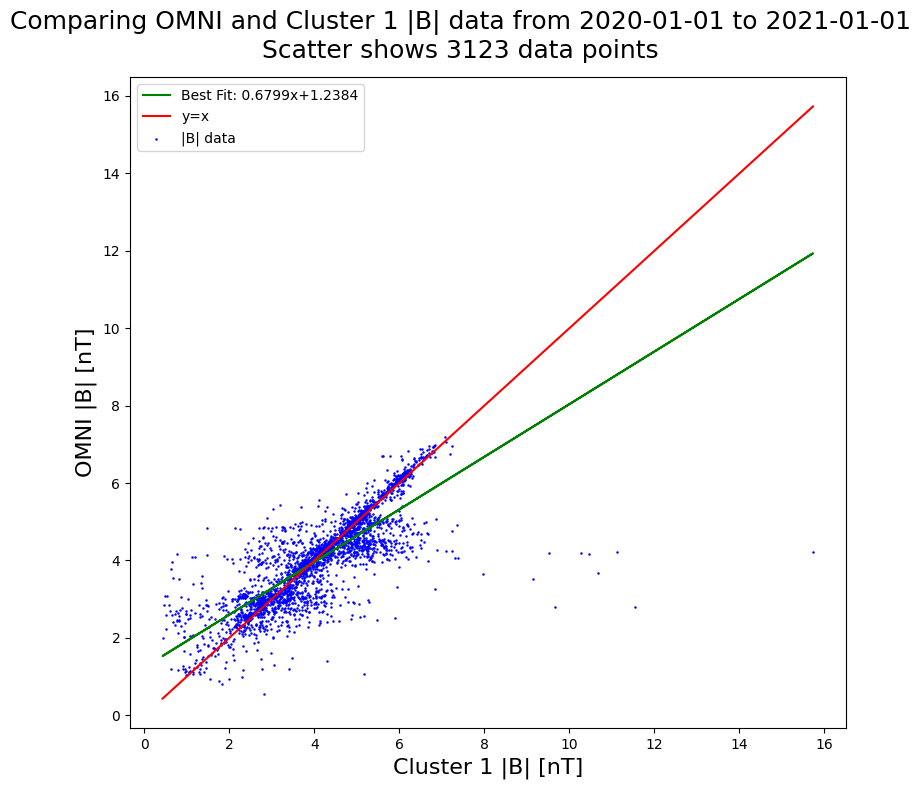

In [31]:
cluster1_sw = filter_cluster(cluster1,'x_dist',15.5)
c1_mask, omni_mask = common_epoch_times(cluster1_sw, omni, 'epoch')
compare_dataframes(cluster1_sw, omni, 'B_mag', 'Cluster 1', 'OMNI', c1_mask, omni_mask, True)

## Further Plots

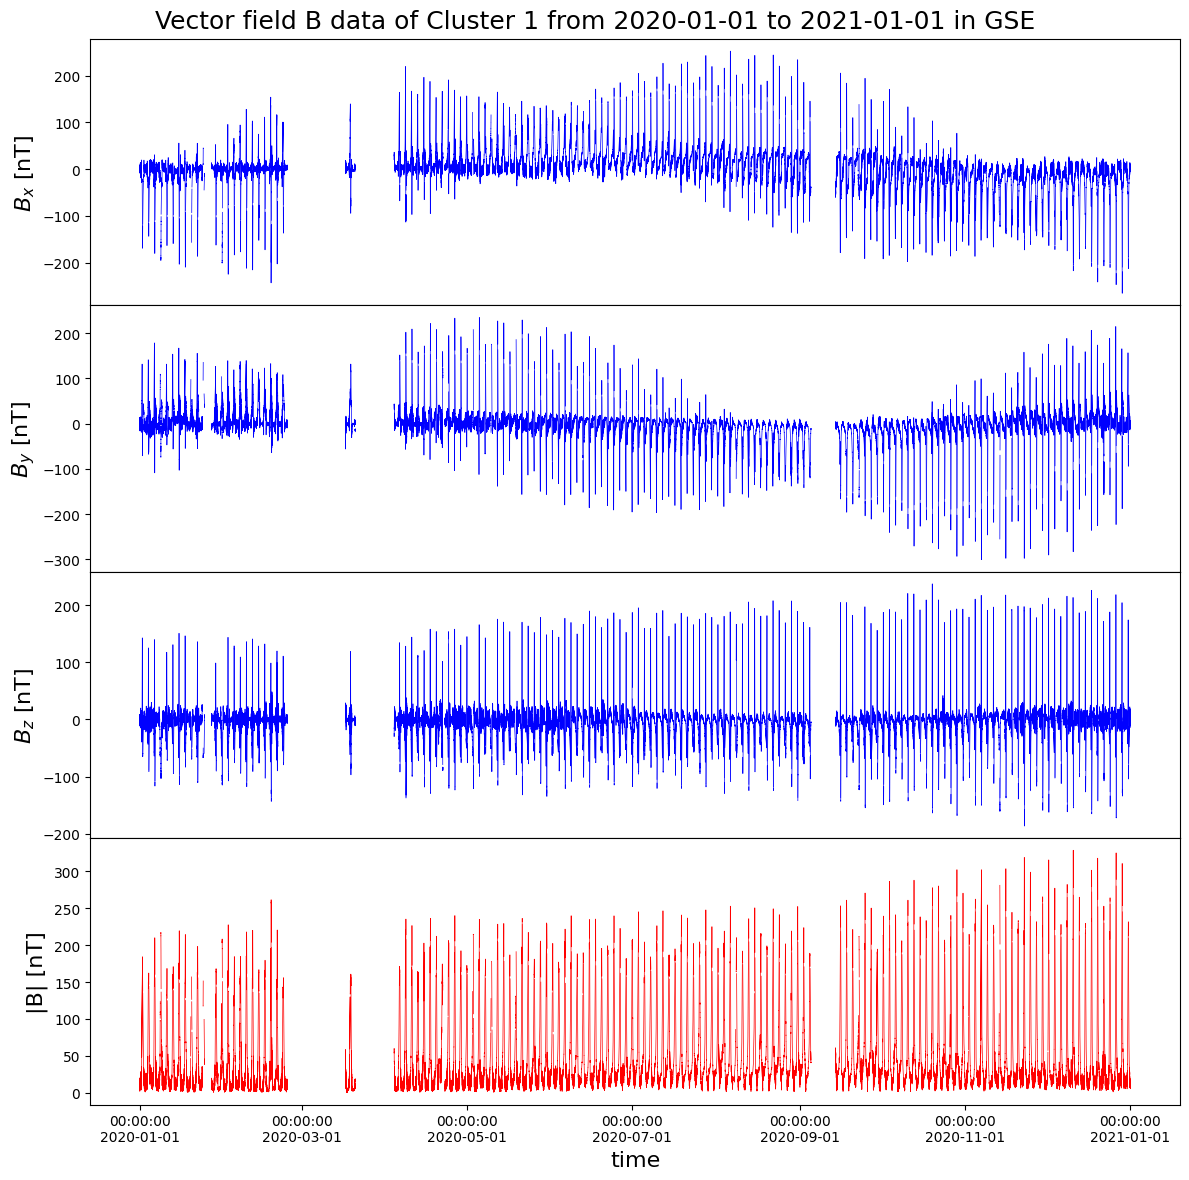

In [20]:
plot_field_data(cluster1, data_name='Cluster 1', field='B', coords='GSE')

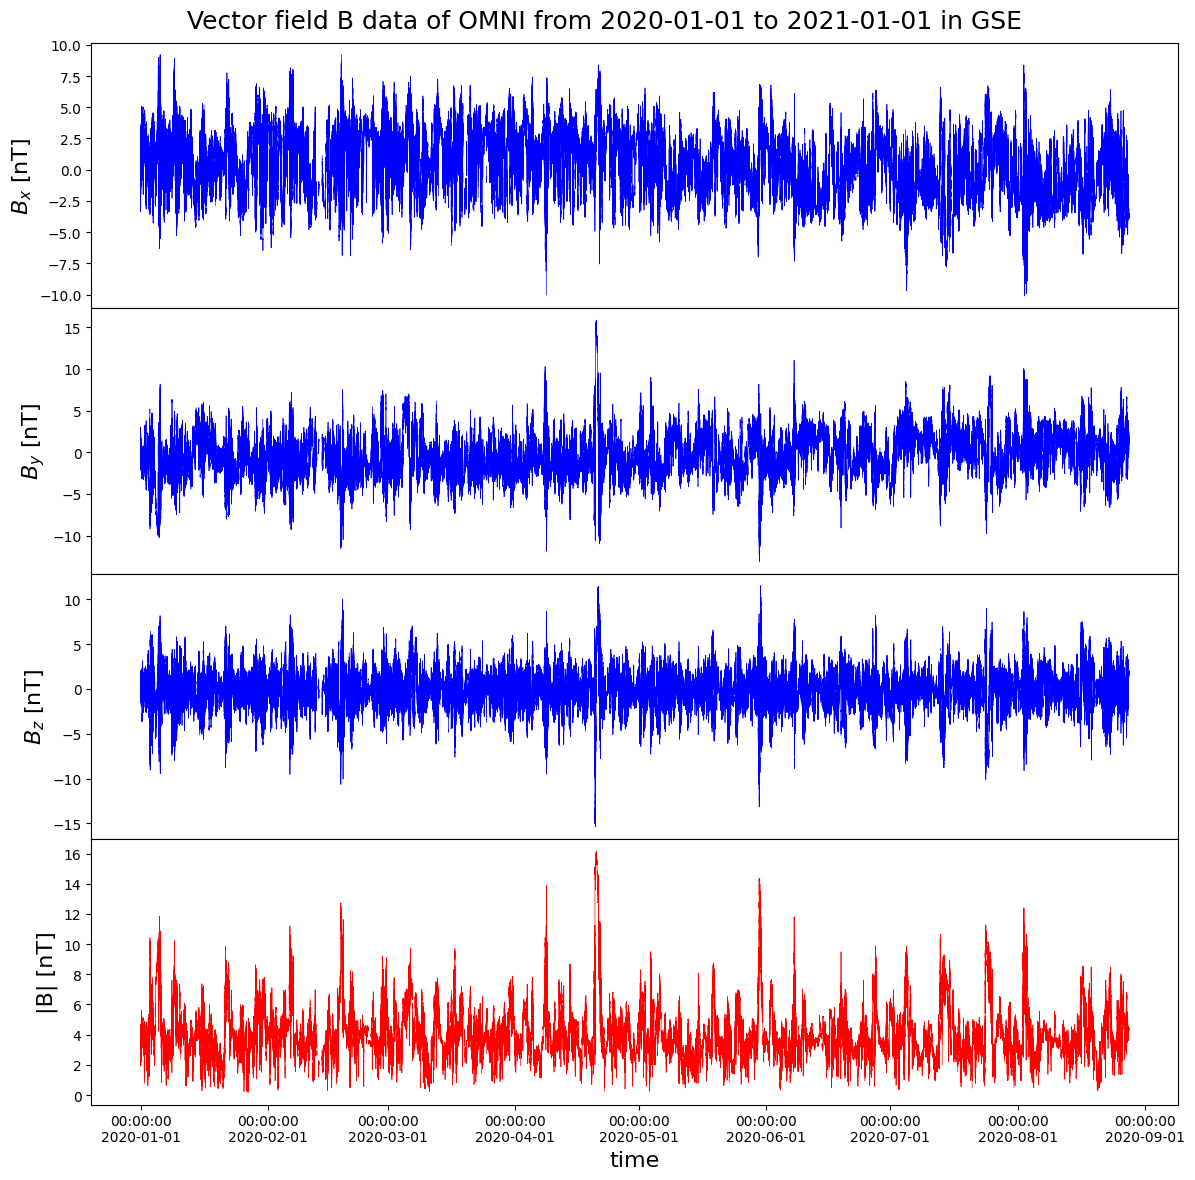

In [21]:
plot_field_data(omni, data_name='OMNI', field='B', coords='GSE')